In [39]:
import numpy as np
import json
import matplotlib.pyplot as plt

# Frequentist
import pyhf
pyhf.set_backend('jax')

# Bayesian
import pymc
import arviz
import corner

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from Bayesian_pyhf import infer
from Bayesian_pyhf import plotting

In [4]:
# import sys
# sys.path.append('....../src')

# from Bayesian_pyhf import infer

# Example 1: Adapted Public Likelihood
- Search for displaced leptons in $\sqrt s$ = 13 TeV $pp$ collisions with the ATLAS detector
- https://www.hepdata.net/record/resource/1981552?landing_page=true

In [41]:
with open('workspaces/SRee_SRmm_Srem.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model=model, include_auxdata=False)

In [42]:
print(f'Observations: {observations}')

Observations: [9.99999993922529e-09, 9.99999993922529e-09, 9.99999993922529e-09]


### Bayesian evaluation:

  $ p(\theta \vert x) \approx p(x \vert \theta)  p(\theta)$

In [44]:
# Fix prior for unconstrained parameters
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'HalfNormal_Unconstrained', 'sigma': [3.]}
}

nDraws = 20_000

In [45]:
# Sample posterior distributions
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_data = pymc.sample(nDraws, chains = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 28 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [46]:
# Sample posterior predictives
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_pred = pymc.sample_posterior_predictive(post_data)

Sampling: [Expected_Data]


In [47]:
# Sample prior predictives
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    prior_pred = pymc.sample_prior_predictive(nDraws)

Sampling: [Expected_Data, SigXSec, cuts_SRmm_LRT, cuts_SRmm_LRTfilter, lumi, mu_Sig, ucbSRee, ucbSRem, ucbSRmm, ucsSRmm_Slep_1000_10, ucsSRmm_disp, ucsSRmm_mu_sel, ucsSRmm_mu_trig, ucsSRmm_pileupWeight]


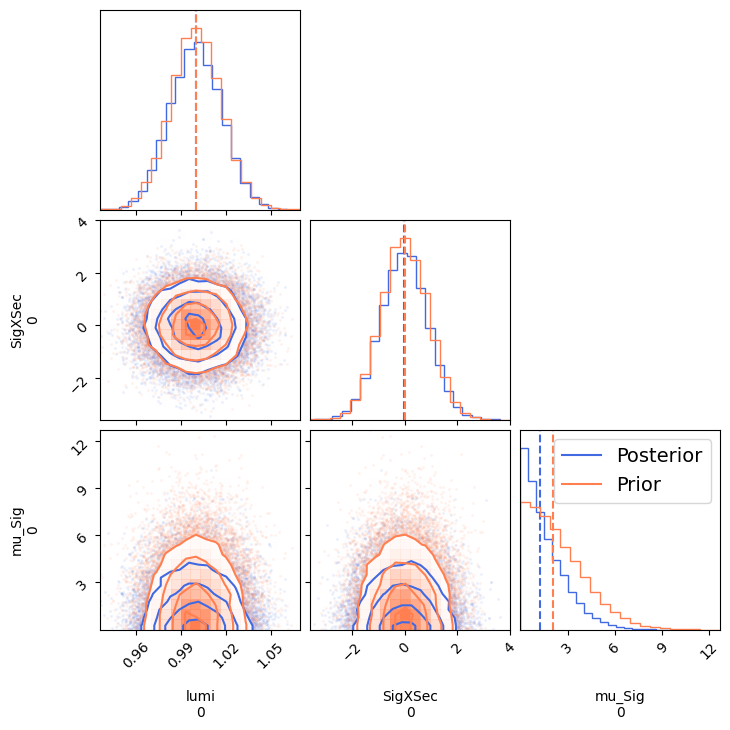

In [49]:
b = corner.corner(post_data.posterior, var_names=['lumi', 'SigXSec', 'mu_Sig'], quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=['lumi', 'SigXSec', 'mu_Sig'], quantiles=[0.5], color = 'coral', fig = b);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)


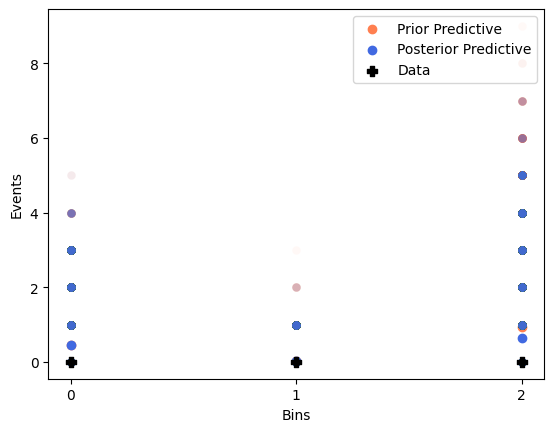

In [50]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred)

# Example 2: Toy $\gamma \gamma$ to Higgs

In [52]:
with open('workspaces/GammaGammaHiggs.json') as serialized:
    workspace = pyhf.Workspace(json.load(serialized))

model = workspace.model()

observations = workspace.data(model=model, include_auxdata=False)
observations_inclAux = workspace.data(model=model, include_auxdata=True)

Frequentist evaluation:

In [53]:
print(f'MLE best fit value for mu: {pyhf.infer.mle.fit(pdf=model, data=observations_inclAux)[model.config.poi_index]}')

MLE best fit value for mu: 1.0755664000067255


Bayesian evaluation:

In [55]:
# Fix prior for unconstrained parameters
unconstr_priors = {
    f'{model.config.poi_name}': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [5.]}
}

nDraws = 20_000

In [56]:
# Sample posterior, and prior and posterior predictive
with infer.model(model, unconstrained_priors=unconstr_priors, data=observations):
    post_data = pymc.sample(nDraws, chains = 1)
    post_pred = pymc.sample_posterior_predictive(post_data)
    prior_pred = pymc.sample_prior_predictive(nDraws)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, NormUncertainty]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [Expected_Data]


Sampling: [Expected_Data, NormUncertainty, mu]


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'NormUncertainty'}>,
        <Axes: title={'center': 'NormUncertainty'}>]], dtype=object)

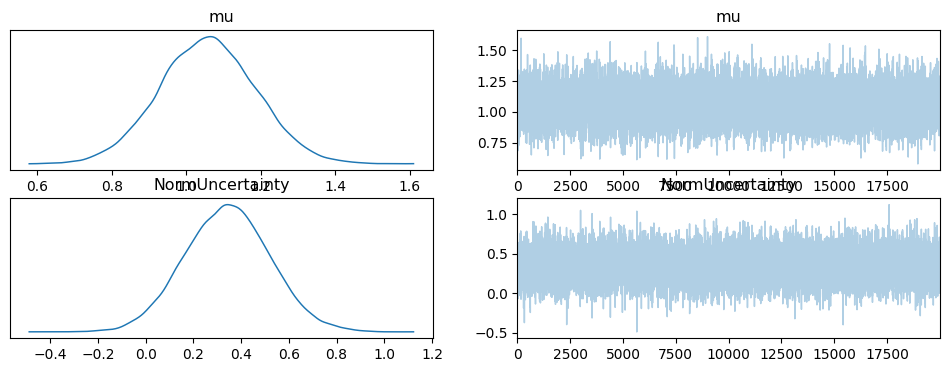

In [57]:
arviz.plot_trace(post_data, var_names=model.config.par_names)

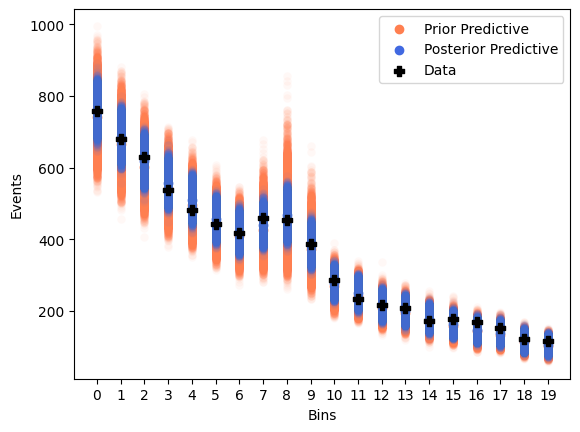

In [58]:
plotting.prior_posterior_predictives(model=model, data=observations, post_pred=post_pred, prior_pred=prior_pred)

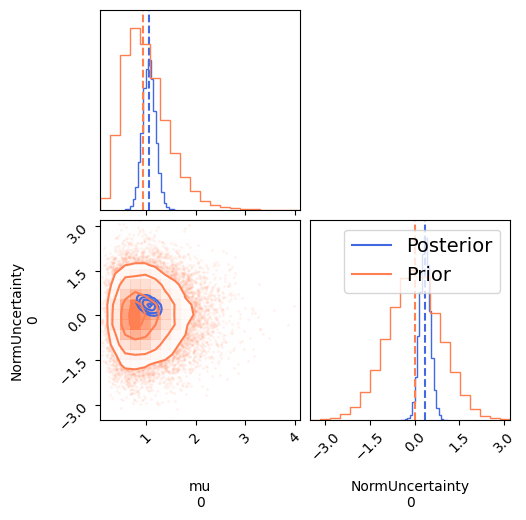

In [59]:
a = corner.corner(post_data.posterior, var_names=model.config.par_names, quantiles=[0.5], color = 'royalblue');
corner.corner(prior_pred.prior, var_names=model.config.par_names, quantiles=[0.5], color = 'coral', fig = a);

import matplotlib.lines as mlines
plt.legend(handles=[
            (mlines.Line2D([], [], color='royalblue', label='Posterior')),
            (mlines.Line2D([], [], color='coral', label='Prior'))
        ], loc="upper right", fontsize=14)

In [60]:
print(f'Posterior mean for mu: {np.array(post_data.posterior.mu[0]).mean()}')

Posterior mean for mu: 1.0580503096874656
